In [1]:
import xarray
from datetime import datetime
from src.mrms_qpe.fetch_mrms_qpe import MRMSQPEClient
    

client = MRMSQPEClient()
date   = datetime(2021, 8, 1, 1, 24)
ar     = client.fetch_radar_only_qpe_1hr(date)

Ignoring index file '__temp/MRMS_RadarOnly_QPE_01H_00.00_20210801-012400.grib2.5b7b6.idx' older than GRIB file


In [2]:
_LAT_MIN = 34.751857
_LAT_MAX = 37.103662
_LON_MIN = -116.146925 + 360
_LON_MAX = -113.792819 + 360

In [3]:
def visualize_mrms_product(xarr: xarray.Dataset, product_name: str="") -> None:
    """
    Display a still frame of an `xarray.Dataset`
    """
    pass


# a grib2 file loaded into an xarray.Dataset
example_arr = ar

# [3500, 7000]; 1H-QPE (mm)
qpe_arr: xarray.DataArray = example_arr.unknown

# N, E
lat_mask    = (qpe_arr.latitude  < _LAT_MAX) & (qpe_arr.latitude  > _LAT_MIN)
lon_mask    = (qpe_arr.longitude < _LON_MAX) & (qpe_arr.longitude > _LON_MIN)
coords_mask = lat_mask & lon_mask

# LV valley region
qpe_arr_lv  = qpe_arr.values[coords_mask]

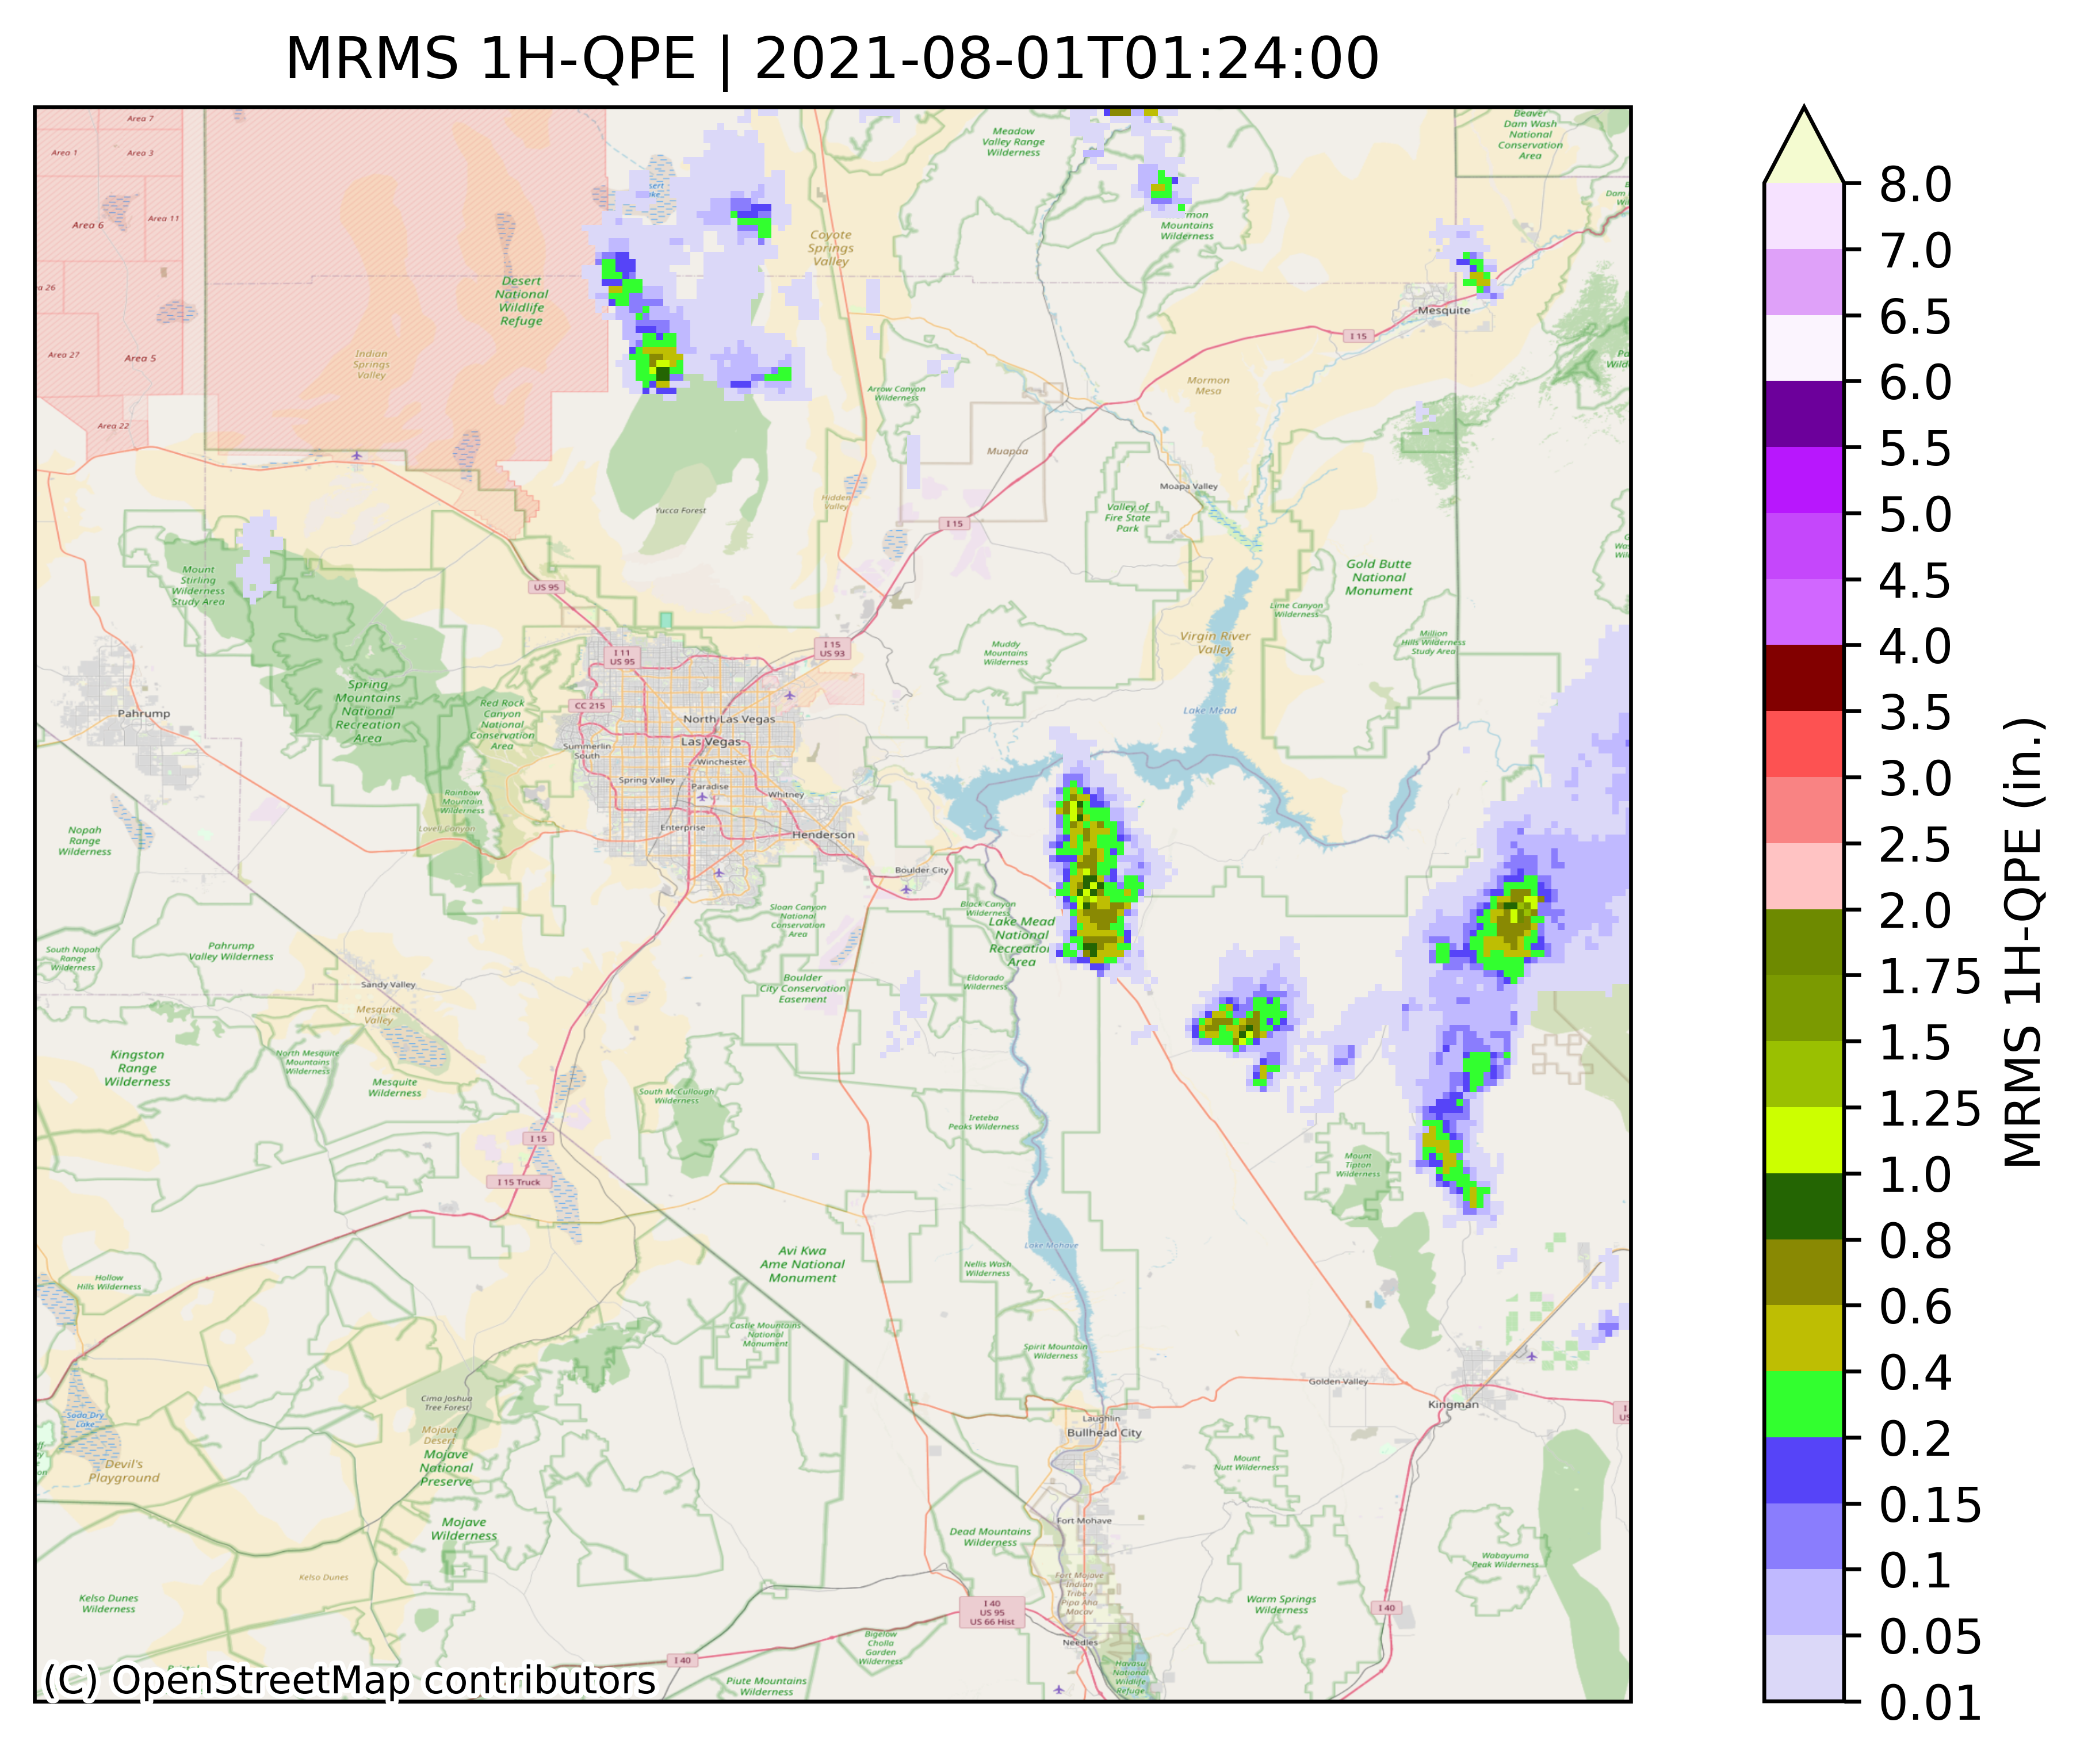

In [4]:
import xarray as xr
import contextily as cx
import xyzservices.providers as xyz
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from src.plot.magic import MRMS_1H_QPE_PALLETE, MRMS_1H_QPE_BOUNDARIES


# pallete from NSSL MRMS web viewer
colors = MRMS_1H_QPE_PALLETE
boundaries = MRMS_1H_QPE_BOUNDARIES

cmap = mcolors.ListedColormap(colors)
cmap.set_bad((0, 0, 0, 0))
norm = mcolors.BoundaryNorm(boundaries, cmap.N, extend='max')

# QPE (mm -> in)
ds = example_arr.unknown.sel(
    latitude=slice(_LAT_MAX,  _LAT_MIN),
    longitude=slice(_LON_MIN, _LON_MAX),
) / 25.4

ds_masked = ds.where(ds >= 0.01)

fig = plt.figure(figsize=(10, 6), dpi=600)
ax  = plt.axes(projection=ccrs.PlateCarree())

# ax.coastlines(resolution='50m', zorder=4)
# ax.add_feature(cfeature.STATES.with_scale('50m'), zorder=4, linewidth=1.1)
# ax.add_feature(cfeature.BORDERS, linewidth=1.2)

# same limits as the data slice
ax.set_extent([_LON_MIN, _LON_MAX, _LAT_MIN, _LAT_MAX], crs=ccrs.PlateCarree())

# add basemap; tell contextily our axis units are degrees
cx.add_basemap(ax, crs="EPSG:4326", source=xyz.OpenStreetMap.Mapnik, zoom=10)

# plot subset
ds_masked.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    norm=norm,
    cmap=cmap,
    add_colorbar=False,
);

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('MRMS 1H-QPE (in.)')
cbar.set_ticks(boundaries)
cbar.set_ticklabels([str(b) for b in boundaries])

plt.title(f"MRMS 1H-QPE | 2021-08-01T01:24:00")
plt.show()